# Course Project

##### Packages and Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import json

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB,MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.gaussian_process import GaussianProcessClassifier
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, CuDNNLSTM
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from tensorflow.keras.utils import plot_model 

import nltk as nlp
from nltk.corpus import stopwords
import string
import re

##### Text Processing functions

In [3]:
"""
Tokenize a text by double line breaks
"""
def line_break_tokenizer(input_text:str):
    # Divide doc input by double line break
    return input_text.split('\n\n')
"""
Tokenize a list of words into paragraph of count size
"""
def word_count_tokenizer(word_col, count):
    # Divide word_list input by double line break
    result = []
    for i in range(0, len(word_col), count):
        result.append(' '.join(word_col[i:i + count]))
        
    return result
"""
Use regex to remove punctuation, numbers and multi spaces
"""
def clean_text(text:str):
    clean = re.sub('[\W_]+', ' ', text.lower())
    clean = re.sub('[\d]+', ' ', clean)
    
    return re.sub(' +', ' ', clean)

def remove_stopwords(text:str):
    stop_words = set(stopwords.words('english'))
    no_stopword = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword)

"""
Preprocess of text
"""
def preprocess(doc, label, sample_size):
    # Divide doc into multiple paragraphs by total word/sample_size
    all_word = clean_text(doc).split()
    paragraphs = word_count_tokenizer(all_word, math.ceil(len(all_word)/sample_size))
    # Create the df with classification
    labels = np.ones((sample_size,)) * label
    df = pd.DataFrame({'paragraph': paragraphs, 'label': labels })
    
    return df, df.count() + 1

##### TF-IDF Calculation

In [4]:
def convert_to_mat(index):
    mat = np.zeros((index.size, index.max()+1))
    mat[np.arange(index.size),index] = 1
    
    return mat

def computeTF(word_list, doc_size):
    tfDict = []
    for i  in range(0, len(word_list)):
        dicts = {}
        for word, count in word_list[i].items():
            dicts[word] = count / float(doc_size)
        tfDict.append(dicts)
        
    return tfDict

def computeIDF(documents, final_word_list):
    N = len(documents)
    
    idfDict = dict.fromkeys(final_word_list, 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        if(val != 0):
            idfDict[word] = float(math.log(float(N) / float(val)))
        else:
            idfDict[word] = 0
            
    return idfDict

def computeTFIDF(doc_word, idfs, key):
    tfidf = []
    for i  in range(len(doc_word)):
        dicts = {}
        for word, val in doc_word[i].items():
            dicts[word] = val * idfs[word]
        dicts['123'] = key
        tfidf.append(dicts)
        
    return tfidf

##### Data Import

In [5]:
movie_data1 = pd.read_csv("movies_metadata.csv")
movie_data1['id'] = movie_data1['id'].astype(int)

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
keyword_data1 = pd.read_csv("movies_keyword.csv")
keyword_data1['id'] = keyword_data1['id'].astype(int)

In [7]:
data1 = movie_data1.join(keyword_data1.set_index('id'), on='id')
data1 = data1.drop(columns=['adult', 'belongs_to_collection',
                          'budget', 'homepage', 'imdb_id', 'original_language',
                          'popularity', 'poster_path', 'production_companies',
                          'production_countries', 'release_date', 'revenue',
                          'runtime', 'spoken_languages', 'status', 'tagline',
                          'video', 'vote_average', 'vote_count', 'original_title', 'id'])
data1.drop_duplicates(inplace=True)
data1.sort_values('title').head(10)

,genres,overview,title,keywords
23841,"[{'id': 99, 'name': 'Documentary'}]","Through intimate interviews, provocative art, ...",!Women Art Revolution,"[{'id': 2383, 'name': 'feminism'}, {'id': 1870..."
28619,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",A pair of horny college guys get summer jobs a...,#1 Cheerleader Camp,"[{'id': 6075, 'name': 'sport'}]"
4385,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...","Inspired by actual events, a group of 12 year ...",#Horror,[]
6030,"[{'id': 99, 'name': 'Documentary'}]",From her childhood bedroom in the Chicago subu...,#chicagoGirl,[]
12146,"[{'id': 37, 'name': 'Western'}]",Johnny Liston has just been released from pris...,"$1,000 on the Black",[]
11302,"[{'id': 18, 'name': 'Drama'}, {'id': 37, 'name...",A stranger rides into Rainbow Valley where he'...,"$100,000 for Ringo","[{'id': 156212, 'name': 'spaghetti western'}, ..."
43536,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...","After being released from jail, the son of a c...",$5 a Day,[]
7155,"[{'id': 18, 'name': 'Drama'}]",When Ross is diagnosed with terminal brain can...,$50K and a Call Girl: A Love Story,[]
36662,"[{'id': 16, 'name': 'Animation'}, {'id': 18, '...","Have you ever wondered ""What is the meaning of...",$9.99,"[{'id': 10183, 'name': 'independent film'}, {'..."
16586,"[{'id': 99, 'name': 'Documentary'}]",Fame today is more than an obsession. Fame has...,$ellebrity,"[{'id': 208403, 'name': 'celebrity photographe..."


In [8]:
movie_data2 = pd.read_csv("wiki_movie_plots_deduped.csv")
data2 =  movie_data2.drop(columns=['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'])
data2.drop_duplicates(inplace=True)
data2.sort_values('Title').head(10)
data2['Genre'] = data2['Genre'].apply(lambda x: x.split(', '))

In [9]:
movie_data3 = pd.read_csv("IMDb_movies.csv")
data3 = movie_data3.drop(columns=['imdb_title_id', 'original_title', 'year', 'date_published',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'])
data3.drop_duplicates(inplace=True)
data3.sort_values('title').head(10)
data3['genre'] = data3['genre'].apply(lambda x: x.split(', '))

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
def json_extract(obj, value):
    arr = []
    try:
        obj = eval(obj)
    except:
        return arr
    def extract(obj, arr, value):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, value)
                elif k == value:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, value)
        return arr
    
    values = extract(obj, arr, value)
    return values

In [11]:
data1['genres'] = data1['genres'].apply(lambda x: json_extract(x, 'name'))
data1['keywords'] = data1['keywords'].apply(lambda x: json_extract(x, 'name'))

In [12]:
data1.tail(10)

,genres,overview,title,keywords
45453,"[Drama, Crime, Music]","Selma, a Czech immigrant on the verge of blind...",Dancer in the Dark,"[individual, dancing, usa, robbery, factory wo..."
45454,"[Mystery, Drama]","Newspaper magnate, Charles Foster Kane is take...",Citizen Kane,"[journalist, newspaper, florida, capitalist, b..."
45455,[Drama],"Lester Burnham, a depressed suburban father in...",American Beauty,"[male nudity, female nudity, adultery, parent ..."
45456,"[Comedy, Drama, Romance]",A man with a low IQ has accomplished great thi...,Forrest Gump,"[vietnam veteran, hippie, mentally disabled, r..."
45457,"[Animation, Family]","Nemo, an adventurous young clownfish, is unexp...",Finding Nemo,"[father son relationship, harbor, underwater, ..."
45458,"[Adventure, Action, Science Fiction]",Princess Leia is captured and held hostage by ...,Star Wars,"[android, galaxy, hermit, death star, lightsab..."
45459,"[Action, Thriller, Crime]","While racing to a boxing match, Frank, Mike, J...",Judgment Night,"[chicago, drug dealer, boxing match, escape, o..."
45460,"[Crime, Comedy]",It's Ted the Bellhop's first night on the job....,Four Rooms,"[hotel, new year's eve, witch, bet, hotel room..."
45461,"[Drama, Comedy]","An episode in the life of Nikander, a garbage ...",Shadows in Paradise,"[salesclerk, helsinki, garbage, independent film]"
45462,"[Drama, Crime]",Taisto Kasurinen is a Finnish coal miner whose...,Ariel,"[underdog, prison, factory worker, prisoner, h..."


In [13]:
data2.head(10)

,Title,Genre,Plot
0,Kansas Saloon Smashers,[unknown],"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,[unknown],"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,[unknown],"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",[unknown],Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,[unknown],The earliest known adaptation of the classic f...
5,Alice in Wonderland,[unknown],"Alice follows a large white rabbit down a ""Rab..."
6,The Great Train Robbery,[western],The film opens with two bandits breaking into ...
7,The Suburbanite,[comedy],The film is about a family who move to the sub...
8,The Little Train Robbery,[unknown],The opening scene shows the interior of the ro...
9,The Night Before Christmas,[unknown],Scenes are introduced using lines of the poem....


In [14]:
data3.head(10)

,title,genre,description
0,Miss Jerry,[Romance],The adventures of a female reporter in the 1890s.
1,The Story of the Kelly Gang,"[Biography, Crime, Drama]",True story of notorious Australian outlaw Ned ...
2,Den sorte drøm,[Drama],Two men of high rank are both wooing the beaut...
3,Cleopatra,"[Drama, History]",The fabled queen of Egypt's affair with Roman ...
4,L'Inferno,"[Adventure, Drama, Fantasy]",Loosely adapted from Dante's Divine Comedy and...
5,"From the Manger to the Cross; or, Jesus of Naz...","[Biography, Drama]","An account of the life of Jesus Christ, based ..."
6,Madame DuBarry,"[Biography, Drama, Romance]","The story of Madame DuBarry, the mistress of L..."
7,Quo Vadis?,"[Drama, History]","An epic Italian film ""Quo Vadis"" influenced ma..."
8,Independenta Romaniei,"[History, War]",The movie depicts the Romanian War of Independ...
9,Richard III,[Drama],Richard of Gloucester uses manipulation and mu...


In [15]:
a = data1[data1['overview'].astype(str).map(len) >=10]
b = a[a['genres'].str.len() > 0]
b['genres'] = b['genres'].apply(lambda x: x[:2])
b.head(20)

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,genres,overview,title,keywords
0,"[Fantasy, Drama]",Manuel is a young boy who travels from long ag...,Manuel on the Island of Wonders,[]
2,"[Drama, Romance]","In the 1910s, beautiful young Silja loses both...",Silja - nuorena nukkunut,[]
3,[Drama],Fifteen-year-old girl Dotty Fisher is assaulte...,Tragedy in a Temporary Town,[]
4,"[Fantasy, Drama]",A horror comedy spoofing conspiracy theory mov...,Abduction,[]
5,[Documentary],An interview session with Arnold Schwarzenegge...,The Making of 'The Terminator': A Retrospective,[making of]
6,[Documentary],"William Shatner sits down with scientists, inn...",The Truth Is in the Stars,"[nature, science, canadian movie]"
7,"[Horror, Science Fiction]","Stranded in an Arctic mine, two survivors are ...",Zygote,[]
8,"[Action, Adventure]","International master thief, Simon Templar, als...",The Saint,[the saint]
9,"[Action, Science Fiction]","Set during the Vietnam war, Firebase follows A...",Firebase,"[vietnam war, short]"
10,"[TV Movie, Drama]","Set in a Norwegian hamlet, an idealistic physi...",An Enemy of the People,[based on play or musical]


In [16]:
b['clean_overview'] = b['overview'].apply(lambda text: clean_text(text))
b['clean_overview'] = b['clean_overview'].apply(lambda text: remove_stopwords(text))

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
sns.set(style="white")
result = b.genres.sort_values().apply(lambda x: sorted(x))
result = pd.DataFrame(result).reset_index(drop=True)
result['genres']=result['genres'].apply(lambda x: ','.join(map(str, x)))
genre_to_count=result.groupby('genres')['genres'].count().reset_index(name='count').sort_values(['count'], ascending=False)
genre_to_count=genre_to_count[genre_to_count['count'] > 200]

genre_to_count

,genres,count
104,Drama,4904
56,Comedy,3370
59,"Comedy,Drama",3105
89,Documentary,2683
112,"Drama,Romance",2063
67,"Comedy,Romance",1403
75,"Crime,Drama",1271
1,"Action,Adventure",1225
6,"Action,Drama",1153
115,"Drama,Thriller",1129


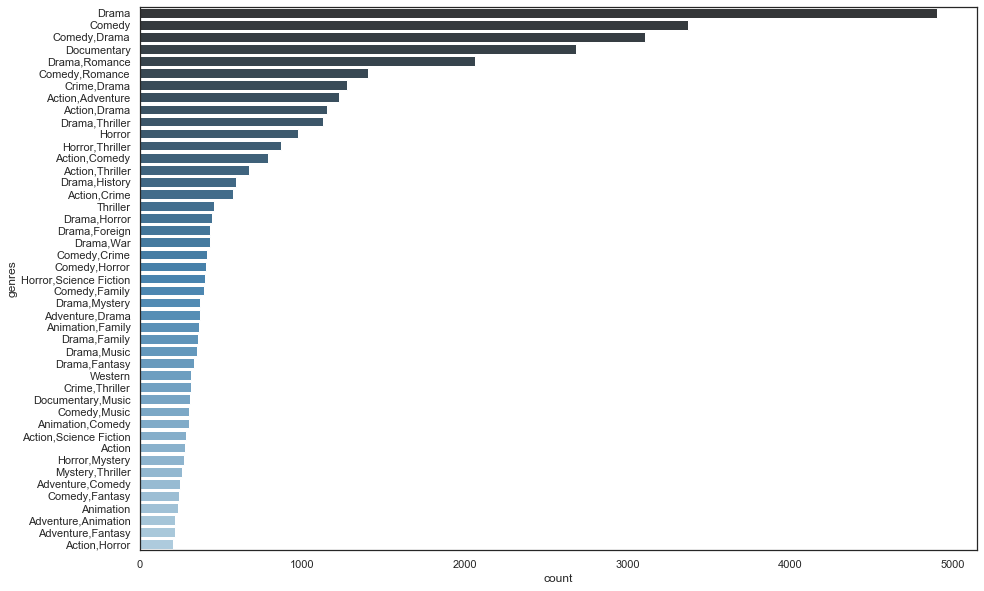

In [18]:
plt.figure(figsize=(15,10))
sns.barplot(y="genres", x="count", data=genre_to_count, palette="Blues_d")

In [19]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(b['genres'])

y = multilabel_binarizer.transform(b['genres'])
tfidf_vectorizer = TfidfVectorizer()

In [20]:
y[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
input_data = b['clean_overview']
x_train1,x_test1,y_train1,y_test1 = train_test_split(input_data, y, test_size=0.2, random_state=2020)
x_half1,x_test_half1,y_half1,y_testfalf1 = train_test_split(input_data, y, test_size=0.5, random_state=2020)
# x_train3,x_test3,y_train3,y_test3 = train_test_split(data3['description'], data3['genre'], test_size=0.2, random_state=2020)

all_tfidf = tfidf_vectorizer.fit_transform(input_data)
xtrain_tfidf = tfidf_vectorizer.transform(x_train1)
xval_tfidf = tfidf_vectorizer.transform(x_test1)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

model = clf.fit(xtrain_tfidf, y_train1)



In [22]:
prediction = model.predict(xval_tfidf > .13).astype(int)
f1_score(y_test1, prediction, average="micro")

0.4685049329623071

In [23]:
print(classification_report(y_test1, prediction))

              precision    recall  f1-score   support

           0       0.40      0.70      0.51      1200
           1       0.23      0.48      0.31       540
           2       0.37      0.46      0.41       358
           3       0.56      0.56      0.56      2320
           4       0.32      0.58      0.41       663
           5       0.43      0.72      0.54       751
           6       0.63      0.66      0.65      3626
           7       0.19      0.42      0.26       343
           8       0.21      0.42      0.28       274
           9       0.04      0.02      0.03       174
          10       0.14      0.39      0.21       150
          11       0.40      0.75      0.52       819
          12       0.33      0.54      0.41       272
          13       0.13      0.37      0.19       259
          14       0.28      0.48      0.35       773
          15       0.31      0.64      0.42       338
          16       0.12      0.06      0.08       106
          17       0.26    

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
svc = LinearSVC()
clf = OneVsRestClassifier(svc)

model = clf.fit(xtrain_tfidf, y_train1)
prediction = model.predict(xval_tfidf)
f1_score(y_test1, prediction, average="micro")

0.47678018575851394

In [25]:
print(classification_report(y_test1, prediction))

              precision    recall  f1-score   support

           0       0.62      0.41      0.49      1200
           1       0.48      0.15      0.23       540
           2       0.73      0.23      0.35       358
           3       0.64      0.47      0.54      2320
           4       0.44      0.14      0.22       663
           5       0.82      0.58      0.68       751
           6       0.65      0.62      0.64      3626
           7       0.43      0.09      0.15       343
           8       0.43      0.05      0.10       274
           9       0.50      0.01      0.01       174
          10       0.57      0.03      0.05       150
          11       0.72      0.46      0.56       819
          12       0.68      0.23      0.35       272
          13       0.32      0.03      0.05       259
          14       0.39      0.13      0.20       773
          15       0.60      0.28      0.38       338
          16       0.00      0.00      0.00       106
          17       0.39    

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
mnb = MultinomialNB()
clf = OneVsRestClassifier(mnb)

model = clf.fit(xtrain_tfidf, y_train1)
prediction = model.predict(xval_tfidf)
f1_score(y_test1, prediction, average="micro")


0.1706759013048049

In [27]:
print(classification_report(y_test1, prediction))

              precision    recall  f1-score   support

           0       0.09      0.00      0.00      1200
           1       0.00      0.00      0.00       540
           2       0.00      0.00      0.00       358
           3       0.83      0.03      0.06      2320
           4       0.05      0.00      0.00       663
           5       0.09      0.00      0.01       751
           6       0.77      0.36      0.49      3626
           7       0.12      0.01      0.01       343
           8       0.00      0.00      0.00       274
           9       0.00      0.00      0.00       174
          10       0.00      0.00      0.00       150
          11       0.05      0.00      0.00       819
          12       0.00      0.00      0.00       272
          13       0.00      0.00      0.00       259
          14       0.00      0.00      0.00       773
          15       0.00      0.00      0.00       338
          16       0.00      0.00      0.00       106
          17       0.11    

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
bnb = BernoulliNB()
clf = OneVsRestClassifier(bnb)

model = clf.fit(xtrain_tfidf, y_train1)
prediction = model.predict(xval_tfidf)
f1_score(y_test1, prediction, average="micro")


0.39431332989255385

In [29]:
print(classification_report(y_test1, prediction))

              precision    recall  f1-score   support

           0       0.53      0.31      0.39      1200
           1       0.23      0.07      0.10       540
           2       0.11      0.01      0.02       358
           3       0.65      0.41      0.50      2320
           4       0.18      0.03      0.06       663
           5       0.62      0.36      0.46       751
           6       0.69      0.63      0.66      3626
           7       0.11      0.01      0.02       343
           8       0.00      0.00      0.00       274
           9       0.00      0.00      0.00       174
          10       0.00      0.00      0.00       150
          11       0.57      0.14      0.23       819
          12       0.20      0.03      0.05       272
          13       0.00      0.00      0.00       259
          14       0.25      0.08      0.12       773
          15       0.26      0.03      0.06       338
          16       0.00      0.00      0.00       106
          17       0.20    

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
gbc = GradientBoostingClassifier(loss = 'deviance', learning_rate = .01, n_estimators = 10, max_depth=5, random_state=2020)
clf = OneVsRestClassifier(gbc)

model = clf.fit(xtrain_tfidf, y_train1)
prediction = model.predict(xval_tfidf)
f1_score(y_test1, prediction, average="micro")


0.0

In [31]:
print(classification_report(y_test1, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1200
           1       0.00      0.00      0.00       540
           2       0.00      0.00      0.00       358
           3       0.00      0.00      0.00      2320
           4       0.00      0.00      0.00       663
           5       0.00      0.00      0.00       751
           6       0.00      0.00      0.00      3626
           7       0.00      0.00      0.00       343
           8       0.00      0.00      0.00       274
           9       0.00      0.00      0.00       174
          10       0.00      0.00      0.00       150
          11       0.00      0.00      0.00       819
          12       0.00      0.00      0.00       272
          13       0.00      0.00      0.00       259
          14       0.00      0.00      0.00       773
          15       0.00      0.00      0.00       338
          16       0.00      0.00      0.00       106
          17       0.00    

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
sgd = SGDClassifier()
clf = OneVsRestClassifier(sgd)

model = clf.fit(xtrain_tfidf, y_train1)
prediction = model.predict(xval_tfidf)
f1_score(y_test1, prediction, average="micro")


0.3298179396092362

In [33]:
print(classification_report(y_test1, prediction))

              precision    recall  f1-score   support

           0       0.91      0.10      0.18      1200
           1       0.00      0.00      0.00       540
           2       0.87      0.06      0.10       358
           3       0.83      0.18      0.30      2320
           4       0.00      0.00      0.00       663
           5       0.89      0.39      0.54       751
           6       0.72      0.55      0.63      3626
           7       0.00      0.00      0.00       343
           8       0.00      0.00      0.00       274
           9       0.00      0.00      0.00       174
          10       0.00      0.00      0.00       150
          11       0.83      0.13      0.22       819
          12       0.00      0.00      0.00       272
          13       0.00      0.00      0.00       259
          14       0.00      0.00      0.00       773
          15       0.67      0.01      0.01       338
          16       0.00      0.00      0.00       106
          17       0.00    

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', algorithm = 'auto')
clf = OneVsRestClassifier(knn)

model = clf.fit(xtrain_tfidf, y_train1)
prediction = model.predict(xval_tfidf)
f1_score(y_test1, prediction, average="micro")


0.35807484586340393

In [35]:
print(classification_report(y_test1, prediction))

              precision    recall  f1-score   support

           0       0.57      0.24      0.34      1200
           1       0.44      0.09      0.14       540
           2       0.73      0.20      0.32       358
           3       0.50      0.30      0.38      2320
           4       0.42      0.09      0.15       663
           5       0.68      0.26      0.38       751
           6       0.58      0.53      0.56      3626
           7       0.52      0.08      0.15       343
           8       0.40      0.05      0.09       274
           9       1.00      0.01      0.02       174
          10       0.30      0.02      0.04       150
          11       0.67      0.23      0.34       819
          12       0.69      0.15      0.24       272
          13       0.27      0.02      0.03       259
          14       0.28      0.06      0.10       773
          15       0.51      0.13      0.21       338
          16       0.25      0.01      0.02       106
          17       0.26    

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
model = Sequential()
model.add(Embedding(1, output_dim=5))
model.add(LSTM(1))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))


plot_model(model, to_file='model1.png')
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [41]:
model.fit(all_tfidf,y,batch_size=2048,epochs=1,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss')])

Train on 33830 samples, validate on 8458 samples
Epoch 1/1
18432/33830 [===============>..............] - ETA: 23:50 - loss: 1.0700 - accuracy: 0.9111

InvalidArgumentError: indices[184,3958] = 1 is not in [0, 1)
	 [[{{node embedding_3/embedding_lookup}}]]

In [42]:
model.save('lstm_model')

AttributeError: module 'tensorflow.keras.optimizers' has no attribute 'TFOptimizer'

In [43]:
book_data = pd.read_csv("booksummaries.txt", delimiter="\t", )
book_data

,Index,symbol,Title,Author,Publish,Genre,Plot
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


In [44]:
book_data['clean_plot'] = book_data['Plot'].apply(lambda text: clean_text(text))
book_data['clean_plot'] = book_data['clean_plot'].apply(lambda text: remove_stopwords(text))

In [45]:
book_data

,Index,symbol,Title,Author,Publish,Genre,Plot,clean_plot
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",old major old boar manor farm calls animals fa...
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",alex teenager living near future england leads...
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,text plague divided five parts town oran thous...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,argument enquiry proceeds series incremental s...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,novel posits space around milky way divided co...
...,...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",prue mckeel rescued brother dowager governess ...
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,reader first meets rapp covert operation iran ...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,book follows rough chronological order switchi...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...,colbert addresses topics including wall street...


In [46]:

book_tfidf = tfidf_vectorizer.transform(book_data['clean_plot'])

prediction = model.predict(book_tfidf > .14).astype(int)

r = multilabel_binarizer.inverse_transform(prediction)


InvalidArgumentError: indices[3,29140] = 1 is not in [0, 1)
	 [[{{node embedding_3/embedding_lookup}}]]

In [ ]:
pd.set_option('display.max_colwidth', None)
book_data[book_data['Index']==48648].Genre

In [ ]:
r[158]